In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *
from scripts.generator_fns import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn, griddata
import gsum
import functools 

%matplotlib inline

In [2]:
class GSUMsandbox:
    def __init__(self, schemescale, observable, inputspace, traintestsplit,
                 gphyperparameters, orderinfo, filenaming,
                 fixed_quantity=[None, None, None, None],
                 x_quantity=[None, None, None]):
        """
        Class for everything involving Jordan Melendez's GSUM library for observables that
        can be plotted against angle.

        Parameters
        ----------
        nn_interaction (str) : two-letter string for two nucleons interacting in observables.
        observable (ObservableBunch) : observable being plotted.
        Lambda_b (float) : breakdown scale (in MeV).
        inputspace (InputSpaceBunch) : input space against which the observable is plotted.
        traintestsplit (TrainTestSplit) : training and testing masks.
        gphyperparameters (GPHyperparameters) : parameters for fitted Gaussian process.
        orderinfo (OrderInfo) : information about the EFT orders and their colors.
        filenaming (FileNaming) : strings for naming the save files.
        fixed_quantity (list) : [fixed_quantity name (str), fixed_quantity value (float), fixed_quantity array (array), fixed_quantity units (str)]
        x_quantity (list) : [x_quantity name (str), x_quantity array (array), x_quantity units (str)]
        posteriorgrid (PosteriorBounds) : xy-grid over which to plot the Lambda-ell posterior pdf.
        """
        self.nn_interaction = "np"
        
        self.schemescale = schemescale

        # information on the observable
        self.observable = observable
        self.observable_name = self.observable.name
        self.observable_label = self.observable.title
        self.data_raw = self.observable.data
        self.data = self.observable.data
        self.ref_type = self.observable.ref_type
        self.observable_units = self.observable.unit_string
        self.constraint = self.observable.constraint

        # energy or angle at which the observable is evaluated, along with all
        # possible energies or angles for evaluation
        self.fixed_quantity_name = []
        self.fixed_quantity_value = []
        self.fixed_quantity_array = []
        self.fixed_quantity_units = []
        for fq in fixed_quantity:
            self.fixed_quantity_name.append(fq[0])
            self.fixed_quantity_value.append(fq[1])
            self.fixed_quantity_array.append(fq[2])
            self.fixed_quantity_units.append(fq[3])

        # angle or energy mesh
        self.x_quantity_name = []
        self.x_quantity_array = []
        self.x_quantity_full = []
        self.x_quantity_units = []
        for xq in x_quantity:
            self.x_quantity_name.append(xq[0])
            self.x_quantity_array.append(xq[1])
            self.x_quantity_full.append(xq[2])
            self.x_quantity_units.append(xq[3])

        # information on the input space
#         self.inputspace = inputspace
        self.vs_what = np.array([])
        self.x = np.array([])
        self.X = np.array([])
        self.caption_coeffs = np.array([])
        self.title_coeffs = np.array([])
        for isp_idx, isp in enumerate(inputspace):
            self.vs_what = np.append(self.vs_what, isp.name)
            self.caption_coeffs = np.append(self.caption_coeffs, isp.caption)
            self.title_coeffs = np.append(self.title_coeffs, isp.title)
#         self.x = np.array(list(itertools.product(tuple(
#                     [isp.input_space(**{"deg_input": self.x_quantity_array[1],
#                                         "p_input": E_to_p(self.x_quantity_array[0],
#                                                           interaction=self.nn_interaction),
#                                         "E_lab": self.x_quantity_array[0],
#                                         "interaction": self.nn_interaction}) for isp in inputspace])
#                               )))
        self.x = gsum.cartesian(*[isp.input_space(**{"deg_input": self.x_quantity_array[1],
                                "p_input": E_to_p(self.x_quantity_array[0],
                                                  interaction=self.nn_interaction),
                                "E_lab": self.x_quantity_array[0],
                                "interaction": self.nn_interaction}) for isp in inputspace])
        print("self.x has shape " + str(np.shape(self.x)))
        print("self.x = " + str(self.x))
        self.X = self.x[..., None]
        print("self.X has shape " + str(np.shape(self.X)))
        
#         print(tuple((np.shape(xq) for xq in self.x_quantity_array)))
#         print((len(self.x_quantity_array)))
        self.x = np.reshape(self.x, 
                           tuple(len(xq) for xq in self.x_quantity_array) + \
                           (len(self.x_quantity_array), ))
        print("self.x has shape " + str(np.shape(self.x)))
        print("self.x = " + str(self.x))
        self.X = np.reshape(self.X, 
                           tuple(len(xq) for xq in self.x_quantity_array) + \
                           (len(self.x_quantity_array), ) + (1, ))
        print("self.X has shape " + str(np.shape(self.X)))

#         information on the train/test split
        self.traintestsplit = traintestsplit
#         self.train_pts_loc = self.traintestsplit.name
#         self.x_train = self.traintestsplit.x_train
#         self.n_train_pts = len(self.x_train)
#         self.x_test = self.traintestsplit.x_test
#         self.n_test_pts = len(self.x_test)
#         self.y_train = self.traintestsplit.y_train
#         self.y_test = self.traintestsplit.y_test
        
        self.train_pts_loc = self.traintestsplit.name
        self.traintestsplit.make_masks(self.x, observable.data)
        self.x_train = self.traintestsplit.x_train
        self.X_train = self.x_train
        self.n_train_pts = np.shape(self.x_train)[0]
        self.x_test = self.traintestsplit.x_test
        self.X_test = self.x_test
        self.n_test_pts = np.shape(self.x_test)[0]
        self.y_train = self.traintestsplit.y_train
        self.y_test = self.traintestsplit.y_test

        # information on the GP hyperparameters
        self.gphyperparameters = gphyperparameters
        self.ls_array = self.gphyperparameters.ls_array
        self.ls_lower = self.gphyperparameters.ls_lower_array
        self.ls_upper = self.gphyperparameters.ls_upper_array
#         for (lsv, lsl, lsu) in zip(gphyperparameters.ls, 
#                                    gphyperparameters.ls_lower, 
#                                    gphyperparameters.ls_upper):
#             self.ls.append(lsv)
#             self.ls_lower.append(lsl)
#             self.ls_upper.append(lsu)
        self.whether_fit_array = self.gphyperparameters.whether_fit_array
        self.center = self.gphyperparameters.center
        self.ratio = self.gphyperparameters.ratio
        self.nugget = self.gphyperparameters.nugget
        self.seed = self.gphyperparameters.seed
        self.df = self.gphyperparameters.df
        self.disp = self.gphyperparameters.disp
        self.std_est = self.gphyperparameters.scale
        self.sd = self.gphyperparameters.sd

        # information on the orders at which the potential is evaluated

        self.orderinfo = orderinfo
        self.nn_orders_full = self.orderinfo.orders_full
        self.excluded = self.orderinfo.excluded
        self.colors = self.orderinfo.colors_array
        self.light_colors = self.orderinfo.lightcolors_array
        self.mask_restricted = self.orderinfo.mask_restricted
        self.orders_restricted = self.orderinfo.orders_restricted
        self.mask_eval = self.orderinfo.mask_eval

        if self.orderinfo.orders_names_dict is None:
            self.orders_names_dict = {
                6: "N4LO+",
                5: "N4LO",
                4: "N3LO",
                3: "N2LO",
                2: "NLO",
            }
        else:
            self.orders_names_dict = self.orderinfo.orders_names_dict
        if self.orderinfo.orders_labels_dict is None:
            self.orders_labels_dict = {6: r'N$^{4}$LO$^{+}$', 5: r'N$^{4}$LO',
                                       4: r'N$^{3}$LO', 3: r'N$^{2}$LO',
                                       2: r'NLO'}
        else:
            self.orders_labels_dict = self.orderinfo.orders_labels_dict

        # information for naming the file
        self.filenaming = filenaming
        self.scheme = self.filenaming.scheme
        self.scale = self.filenaming.scale
        self.Q_param = self.filenaming.Q_param
        self.p_param = self.filenaming.p_param
        self.filename_addendum = self.filenaming.filename_addendum

#         # for plotting observables at a fixed energy
#         if self.fixed_quantity_name == "energy":
#             self.fixed_idx = np.nonzero(self.fixed_quantity_array == self.fixed_quantity_value)[0][0]

#             self.data = self.data[:, self.fixed_idx, :].T

#             self.X_train = self.x_train[:, None]
#             self.y_train = self.y_train[:, self.fixed_idx, :].T
#             self.X_test = self.x_test[:, None]
#             self.y_test = self.y_test[:, self.fixed_idx, :].T

#             # determines the reference scale for the truncation-error model, including for
#             # training and testing
#             if self.ref_type == "dimensionless":
#                 self.ref = np.ones(len(self.x)) * 1
#                 self.ref_train = np.ones(len(self.x_train)) * 1
#                 self.ref_test = np.ones(len(self.x_test)) * 1

#             elif self.ref_type == "dimensionful":
#                 self.ref = self.data[:, -1]

#                 self.interp_f_ref = interp1d(self.x, self.ref)
#                 self.ref_train = self.interp_f_ref(self.x_train)
#                 self.ref_test = self.interp_f_ref(self.x_test)

#         # for plotting observables at a fixed angle
#         elif self.fixed_quantity_name == "angle":
#             if self.fixed_quantity_value == 0:
#                 self.X_train = self.x_train[:, None]
#                 self.y_train = self.y_train.T
#                 self.X_test = self.x_test[:, None]
#                 self.y_test = self.y_test.T
#             else:
#                 self.fixed_idx = np.nonzero(self.fixed_quantity_array == self.fixed_quantity_value)[0][0]

#                 self.data = self.data[:, :, self.fixed_idx].T

#                 self.X_train = self.x_train[:, None]
#                 self.y_train = self.y_train[:, self.fixed_idx, :].T
#                 self.X_test = self.x_test[:, None]
#                 self.y_test = self.y_test[:, self.fixed_idx, :].T

#             # determines the reference scale for the truncation-error model, including for
#             # training and testing
#             if self.ref_type == "dimensionless":
#                 self.ref = np.ones(len(self.x)) * 1
#                 self.ref_train = np.ones(len(self.x_train)) * 1
#                 self.ref_test = np.ones(len(self.x_test)) * 1
#             elif self.ref_type == "dimensionful":
#                 if self.fixed_quantity_value == 0:
#                     self.ref = self.data[-1]
#                     self.data = self.data.T
#                 else:
#                     self.ref = self.data[:, -1]

#                 self.interp_f_ref = interp1d(self.x, self.ref)
#                 self.ref_train = self.interp_f_ref(self.x_train)
#                 self.ref_test = self.interp_f_ref(self.x_test)

#         # uses interpolation to find the proper reference scales
#         self.interp_f_ref = interp1d(self.x, self.ref)
        
        # data
        print("self.data has shape " + str(np.shape(self.data)))
        mymask = functools.reduce(np.multiply, 
                        np.ix_(*[np.isin(xqfull, xqval).astype(int) for (xqfull, xqval) in 
                                 zip(self.x_quantity_full, self.x_quantity_array)]))
        print("mymask has shape " + str(np.shape(mymask)))
        mymask_tiled = np.tile(mymask, (np.shape(self.data)[0], ) + 
                         (1, ) * (self.data.ndim - 1)
                        )
        print("mymask_tiled has shape " + str(np.shape(mymask_tiled)))
        self.data = self.data[mymask_tiled.astype(bool)]
        print("self.data has shape " + str(np.shape(self.data)))
        self.data = np.reshape(self.data, (np.shape(mymask_tiled)[0], ) + 
                        tuple([len(arr) for arr in self.x_quantity_array]))
        print("self.data has shape " + str(np.shape(self.data)))
        
        # ref
        if self.ref_type == "dimensionless":
            self.ref = np.ones(np.shape(self.data)[1:])
            print("self.ref has shape " + str(np.shape(self.ref)))
            
#             print(np.shape(self.x[mymask.astype(bool)]))
#             print(np.shape(np.reshape(self.ref, (np.prod(np.shape(self.ref)), ))))
#             print(np.shape(self.x_train))
            self.ref_train = np.ones(np.shape(self.x_train)[0])
            print("self.ref_train has shape " + str(np.shape(self.ref_train)))
            
            self.ref_test = np.ones(np.shape(self.x_test)[0])
            print("self.ref_test has shape " + str(np.shape(self.ref_test)))
            
        elif self.ref_type == "dimensionful":
            self.ref = self.data[-1, ...]
            print("self.ref has shape " + str(np.shape(self.ref)))
            
#             print(np.shape(self.x[mymask.astype(bool)]))
#             print(np.shape(np.reshape(self.ref, (np.prod(np.shape(self.ref)), ))))
#             print(np.shape(self.x_train))
            self.ref_train = griddata(
                            self.x[mymask.astype(bool)], 
                            np.reshape(self.ref, (np.prod(np.shape(self.ref)), )), 
                            self.x_train
                        )
            print("self.ref_train has shape " + str(np.shape(self.ref_train)))
            
            self.ref_test = griddata(
                            self.x[mymask.astype(bool)], 
                            np.reshape(self.ref, (np.prod(np.shape(self.ref)), )), 
                            self.x_test
                        )
            print("self.ref_test has shape " + str(np.shape(self.ref_test)))
            
        # ratio
        print("self.ratio has shape " + str(np.shape(self.ratio)))
        self.ratio = np.reshape(self.ratio[mymask.astype(bool)], np.shape(self.data)[1:])
        print("self.ratio has shape " + str(np.shape(self.ratio)))
        self.ratio_train = griddata(
                        self.x[mymask.astype(bool)], 
                        np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )), 
                        self.x_train
                    )
        print("self.ratio_train has shape " + str(np.shape(self.ratio_train)))

        self.ratio_test = griddata(
                        self.x[mymask.astype(bool)], 
                        np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )), 
                        self.x_test
                    )
        print("self.ratio_test has shape " + str(np.shape(self.ratio_test)))
        
        print(np.shape(self.data))
        print(np.shape(self.ratio))
        print(np.shape(self.ref))
        print(np.shape(self.nn_orders_full))
        # Extract the coefficients and define kernel
        self.coeffs = gm.coefficients(np.reshape(self.data, (np.shape(self.data)[0], ) + 
                                                 (np.prod(np.shape(self.data)[1:]), )).T, 
                                      ratio=np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )),
                                      ref=np.reshape(self.ref, (np.prod(np.shape(self.ratio)), )), 
                                      orders=self.nn_orders_full)
        print("self.coeffs has shape " + str(np.shape(self.coeffs)))

        # uses interpolation to find the proper ratios for training and testing
#         self.interp_f_ratio = interp1d(self.x, self.ratio * np.ones(len(self.x)))
#         self.ratio_train = self.interp_f_ratio(self.x_train)
#         self.coeffs_train = gm.coefficients(self.y_train, ratio=self.ratio_train,
#                                             ref=self.ref_train,
#                                             orders=self.nn_orders_full)
#         self.ratio_test = self.interp_f_ratio(self.x_test)
#         self.coeffs_test = gm.coefficients(self.y_test, ratio=self.ratio_test,
#                                            ref=self.ref_test,
#                                            orders=self.nn_orders_full)
        
        self.coeffs_train = gm.coefficients(self.y_train.T, 
                                      ratio=self.ratio_train,
                                      ref=self.ref_train, 
                                      orders=self.nn_orders_full)
        print("self.coeffs_train has shape " + str(np.shape(self.coeffs_train)))
        self.coeffs_test = gm.coefficients(self.y_test.T, 
                                      ratio=self.ratio_test,
                                      ref=self.ref_test, 
                                      orders=self.nn_orders_full)
        print("self.coeffs_test has shape " + str(np.shape(self.coeffs_test)))

        # defines the kernel
#         if self.fixed_quantity_name == "energy" and \
#                 self.fixed_quantity_value < 70.1 and \
#                 self.fixed_quantity_value >= 1.:
#             self.kernel = RBF(length_scale=self.ls,
#                               length_scale_bounds=(self.ls_lower, self.ls_upper)) + \
#                           WhiteKernel(1e-6, noise_level_bounds='fixed')
#         else:
#             self.kernel = RBF(length_scale=self.ls, \
#                               length_scale_bounds=(self.ls_lower, self.ls_upper)) + \
#                           WhiteKernel(1e-10, noise_level_bounds='fixed')
        self.kernel = RBF(length_scale=self.ls_array, 
                length_scale_bounds=np.array([[lsl, lsu] 
                        for (lsl, lsu) in zip(self.ls_lower, self.ls_upper)])) + \
            WhiteKernel(1e-6, noise_level_bounds='fixed')

        # Define the GP
        self.gp = gm.ConjugateGaussianProcess(
            self.kernel, center=self.center, disp=self.disp, df=self.df,
            scale=self.std_est, n_restarts_optimizer=50, random_state=self.seed,
            sd=self.sd)

        # restricts coeffs and colors to only those orders desired for
        # evaluating statistical diagnostics
        self.nn_orders = self.orders_restricted
        print(np.shape(self.coeffs))
        print(np.shape(self.mask_restricted))
        self.coeffs = (self.coeffs.T[self.mask_restricted]).T
        self.coeffs_train = (self.coeffs_train.T[self.mask_restricted]).T
        self.coeffs_test = (self.coeffs_test.T[self.mask_restricted]).T

    def plot_coefficients(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
        # optimizes the ConjugateGaussianProcess for the given parameters and extracts the
        # length scale
        print("self.X_train has shape " + str(np.shape(self.X_train)))
        print("self.coeffs_train has shape " + str(np.shape(self.coeffs_train)))
        self.gp.fit(self.X_train, self.coeffs_train)
        self.ls_true = np.exp(self.gp.kernel_.theta)
        print("self.ls_true = " + str(self.ls_true))

# #         print("self.X has shape " + str(np.shape(self.X)))
#         self.pred, self.std = self.gp.predict(np.reshape(self.x, 
#                                 (np.prod(np.shape(self.x)[:-1]), ) + (np.shape(self.x)[-1], )), 
#                     return_std=True)
        print("self.X_test has shape " + str(np.shape(self.X_test)))
        self.pred, self.std = self.gp.predict(self.X_test,
                    return_std=True)
        self.underlying_std = np.sqrt(self.gp.cov_factor_)
        print("self.underlying_std = " + str(self.underlying_std))

        if np.shape(self.x)[-1] == 1:
            # plots the coefficients against the given input space
            if ax is None:
                fig, ax = plt.subplots(figsize=(3.2, 2.2))

            for i, n in enumerate(self.nn_orders_full[self.mask_restricted]):
                ax.fill_between(self.x, self.pred[:, i] + 2 * self.std,
                                self.pred[:, i] - 2 * self.std,
                                facecolor=self.light_colors[i], edgecolor=self.colors[i],
                                lw=edgewidth, alpha=1, zorder=5 * i - 4)
                ax.plot(self.x, self.pred[:, i], color=self.colors[i], ls='--', zorder=5 * i - 3)
                ax.plot(self.x, self.coeffs[:, i], color=self.colors[i], zorder=5 * i - 2)
                ax.plot(self.x_train, self.coeffs_train[:, i], color=self.colors[i],
                        ls='', marker='o',
                        # label=r'$c_{}$'.format(n),
                        zorder=5 * i - 1)

            # Format
            ax.axhline(2 * self.underlying_std, 0, 1, color=gray, zorder=-10, lw=1)
            ax.axhline(-2 * self.underlying_std, 0, 1, color=gray, zorder=-10, lw=1)
            ax.axhline(0, 0, 1, color=softblack, zorder=-10, lw=1)
            if np.max(self.x) < 1.1:
                ax.set_xticks(self.x_test, minor=True)
                ax.set_xticks([round(xx, 1) for xx in self.x_train])
            else:
                ax.set_xticks(self.x_test, minor=True)
                ax.set_xticks([round(xx, 0) for xx in self.x_train])
            ax.tick_params(which='minor', bottom=True, top=False)
            ax.set_xlabel(self.caption_coeffs)
            ax.set_yticks(ticks=[-2 * self.underlying_std, 2 * self.underlying_std])
            ax.set_yticklabels(labels=['{:.1f}'.format(-2 * self.underlying_std), '{:.1f}'.format(2 * self.underlying_std)])
            ax.set_yticks([-1 * self.underlying_std, self.underlying_std], minor=True)
            ax.legend(
                # ncol=2,
                borderpad=0.4,
                # labelspacing=0.5, columnspacing=1.3,
                borderaxespad=0.6,
                loc = 'best',
                title = self.title_coeffs).set_zorder(5 * i)

            # takes constraint into account, if applicable
            if self.constraint is not None and self.constraint[2] == self.x_quantity_name:
                dX = np.array([[self.x[i]] for i in self.constraint[0]])
                # std_interp = np.sqrt(np.diag(
                #     self.gp.cov(self.X) -
                #     self.gp.cov(self.X, dX) @ np.linalg.solve(self.gp.cov(dX, dX), self.gp.cov(dX, self.X))
                # ))
                _, std_interp = self.gp.predict(self.X,
                                                Xc=dX,
                                                y=np.array(self.constraint[1]),
                                                return_std=True)
                ax.plot(self.x, 2 * std_interp, color='gray', ls='--', zorder=-10, lw=1)
                ax.plot(self.x, -2 * std_interp, color='gray', ls='--', zorder=-10, lw=1)

            # draws length scales
            # ax.annotate("", xy=(np.min(self.x), -0.65 * 2 * self.underlying_std),
            #             xytext=(np.min(self.x) + self.ls, -0.65 * 2 * self.underlying_std),
            #             arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
            #                             color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            # ax.text(np.min(self.x) + self.ls + 0.2 * (np.max(self.x) - np.min(self.x)),
            #         -0.65 * 2 * self.underlying_std, r'$\ell_{\mathrm{guess}}$', fontsize=14,
            #         horizontalalignment='right', verticalalignment='center', zorder=5 * i)

            ax.annotate("", xy=(np.min(self.x), -0.9 * 2 * self.underlying_std),
                        xytext=(np.min(self.x) + self.ls_true, -0.9 * 2 * self.underlying_std),
                        arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                                        color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            ax.text(np.min(self.x) + self.ls_true + 0.2 * (np.max(self.x) - np.min(self.x)),
                    -0.9 * 2 * self.underlying_std, r'$\ell_{\mathrm{fit}}$', fontsize=14,
                    horizontalalignment='right', verticalalignment='center', zorder=5 * i)

            # draws standard deviations
            # ax.annotate("", xy=(np.min(self.x) + 0.90 * (np.max(self.x) - np.min(self.x)), 0),
            #             xytext=(np.min(self.x) + 0.90 * (np.max(self.x) - np.min(self.x)),
            #                     -1. * self.std_est),
            #             arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
            #                             color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            # ax.text(np.min(self.x) + 0.90 * (np.max(self.x) - np.min(self.x)),
            #         -1.2 * self.std_est, r'$\sigma_{\mathrm{guess}}$', fontsize=14,
            #         horizontalalignment='center', verticalalignment='bottom', zorder=5 * i)

            ax.annotate("", xy=(np.min(self.x) + 0.74 * (np.max(self.x) - np.min(self.x)), 0),
                        xytext=(np.min(self.x) + 0.74 * (np.max(self.x) - np.min(self.x)),
                                -1. * self.underlying_std),
                        arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                                        color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            ax.text(np.min(self.x) + 0.74 * (np.max(self.x) - np.min(self.x)),
                    -1.2 * self.underlying_std, r'$\sigma_{\mathrm{fit}}$', fontsize=14,
                    horizontalalignment='center', verticalalignment='bottom', zorder=5 * i)
        elif np.shape(self.x)[-1] == 2:
            print(np.shape(self.coeffs)[-1])
            fig, ax_array = plt.subplots(np.shape(self.coeffs)[-1], 1, 
                figsize=(3.2, np.shape(self.coeffs)[-1] * 2.2))
            
            x_train_scatter, y_train_scatter = self.x_train.T
            x_test_scatter, y_test_scatter = self.x_test.T
            
            for i, n in enumerate(self.orders_restricted):
                ax_array[i].contourf(self.x[..., 0], self.x[..., 1],
                                   np.reshape(self.coeffs[..., i], np.shape(self.x)[:-1]), 
                                   cmap = self.schemescale.extra[i])
                ax_array[i].scatter(x_train_scatter, y_train_scatter, c = 'black', s = 12)
                ax_array[i].scatter(x_test_scatter, y_test_scatter, c = 'gray', s = 2)
                
                ax_array[i].set_xlim(
                    np.amin(self.x[..., 0]) - 0.03 * (np.amax(self.x[..., 0]) - np.amin(self.x[..., 0])), 
                    np.amax(self.x[..., 0]) + 0.03 * (np.amax(self.x[..., 0]) - np.amin(self.x[..., 0]))
                )
                ax_array[i].set_ylim(
                    np.amin(self.x[..., 1]) - 0.03 * (np.amax(self.x[..., 1]) - np.amin(self.x[..., 1])), 
                    np.amax(self.x[..., 1]) + 0.03 * (np.amax(self.x[..., 1]) - np.amin(self.x[..., 1]))
                )
                
                ax_array[i].arrow((1.06 - 1) / (2 * 1.06), 
                                  (1.06 - 1) / (2 * 1.06), 
                                  self.ls_true[0] / 1.06 / (np.amax(self.x[..., 0]) - np.amin(self.x[..., 0])), 
                                  0, 
                                  facecolor = 'black', head_length = 0.05, 
                                  shape = 'left', width = 0.01, head_width = 0.05,
                                  length_includes_head = True, transform=ax_array[i].transAxes)
                ax_array[i].arrow((1.06 - 1) / (2 * 1.06), 
                                  (1.06 - 1) / (2 * 1.06), 
                                  0, 
                                  self.ls_true[1] / 1.06 / (np.amax(self.x[..., 1]) - np.amin(self.x[..., 1])), 
                                  facecolor = 'black', head_length = 0.05, 
                                  shape = 'right', width = 0.01, head_width = 0.05,
                                  length_includes_head = True, transform=ax_array[i].transAxes)
                
                ax_array[i].set_ylabel(self.caption_coeffs[1])
                
            ax_array[i].set_xlabel(self.caption_coeffs[0])
        # saves figure
        if 'fig' in locals() and whether_save:
            fig.tight_layout()

            fig.savefig(('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                         '_' + 'interp_and_underlying_processes' + '_' + str(self.fixed_quantity_value) + str(
                        self.fixed_quantity_units) + \
                         '_' + self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                         '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                         self.train_pts_loc + '_' + self.p_param +
                         self.filename_addendum).replace('_0MeVlab_', '_'))

    def plot_md(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
        try:
            # calculates and plots the squared Mahalanobis distance
            self.gp.kernel_

            # takes into account a constraint, if applicable
            if self.constraint is not None and self.constraint[2] == self.x_quantity_name:
                dX = np.array([[self.x[i]] for i in self.constraint[0]])
                self.mean, self.cov = self.gp.predict(self.X_test,
                                                      Xc=dX,
                                                      y=np.array(self.constraint[1]),
                                                      return_std=False,
                                                      return_cov=True)
            else:
                self.mean = self.gp.mean(self.X_test)
                self.cov = self.gp.cov(self.X_test)
            self.gr_dgn = gm.GraphicalDiagnostic(self.coeffs_test,
                                                 self.mean,
                                                 self.cov,
                                                 colors=self.colors,
                                                 gray=gray,
                                                 black=softblack)

            if ax is None:
                fig, ax = plt.subplots(figsize=(1.0, 2.2))

            self.gr_dgn.md_squared(type='box', trim=False, title=None,
                                   xlabel=r'$\mathrm{D}_{\mathrm{MD}}^2$', ax=ax,
                                   **{"size": 10})
            offset_xlabel(ax)
            plt.show()

            # saves figure
            if 'fig' in locals() and whether_save:
                fig.tight_layout();

                fig.savefig(('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                             '_' + 'md' + '_' + str(self.fixed_quantity_value) + str(self.fixed_quantity_units) + '_' + \
                             self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                             '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                             self.train_pts_loc + '_' + self.p_param +
                             self.filename_addendum).replace('_0MeVlab_', '_'))

        except:
            print("Error in calculating or plotting the Mahalanobis distance.")

    def plot_pc(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
        try:
            # calculates and plots the pivoted Cholesky decomposition
            self.gp.kernel_

            # takes into account constraints, if applicable
            if self.constraint is not None and self.constraint[2] == self.x_quantity_name:
                dX = np.array([[self.x[i]] for i in self.constraint[0]])
                self.mean, self.cov = self.gp.predict(self.X_test,
                                                      Xc=dX,
                                                      y=np.array(self.constraint[1]),
                                                      return_std=False,
                                                      return_cov=True)
            else:
                self.mean = self.gp.mean(self.X_test)
                self.cov = self.gp.cov(self.X_test)
            self.gr_dgn = gm.GraphicalDiagnostic(self.coeffs_test,
                                                 self.mean,
                                                 self.cov,
                                                 colors=self.colors,
                                                 gray=gray,
                                                 black=softblack)

            with plt.rc_context({"text.usetex": True}):
                if ax is None:
                    fig, ax = plt.subplots(figsize=(3.2, 2.2))

                self.gr_dgn.pivoted_cholesky_errors(ax=ax, title=None)
                ax.set_xticks(np.arange(2, self.n_test_pts + 1, 2))
                ax.set_xticks(np.arange(1, self.n_test_pts + 1, 2), minor=True)
                ax.text(0.05, 0.95, r'$\mathrm{D}_{\mathrm{PC}}$', bbox=text_bbox,
                        transform=ax.transAxes, va='top', ha='left')

                # plots legend
                legend_handles = []
                for i, n in enumerate(self.nn_orders_full[self.mask_restricted]):
                    # legend_handles.append(Patch(color=self.colors[i], label=r'$c_{}$'.format(n)))
                    legend_handles.append(Line2D([0], [0], marker='o',
                                            color='w',
                                            label=r'$c_{}$'.format(n),
                                            markerfacecolor=self.colors[i],
                                            markersize=8))
                ax.legend(handles=legend_handles,
                          loc='center left',
                          bbox_to_anchor=(1, 0.5),
                          handletextpad=0.02,
                          borderpad=0.2)

                fig.tight_layout()
                plt.show()

                # saves figure
                if 'fig' in locals() and whether_save:
                    fig.tight_layout()

                    fig.savefig(('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                                 '_' + 'pc_vs_index' + '_' + str(self.fixed_quantity_value) + str(
                                self.fixed_quantity_units) + '_' + \
                                 self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                                 '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                                 self.train_pts_loc + '_' + self.p_param +
                                 self.filename_addendum).replace('_0MeVlab_', '_'))

        except:
            print("Error in calculating or plotting the pivoted Cholesky decomposition.")

In [3]:
ScaleScheme2D = RKE500MeV

t_lab = ScaleScheme2D.get_data("t_lab")
degrees = ScaleScheme2D.get_data("degrees")

E_lab = t_lab
angle_lab = degrees
# E_angle_pair = [E_lab, angle_lab]
E_angle_pair = [E_lab, angle_lab]
# E_angle_pair = [, ]
# print(E_angle_pair)

DSGBunch = ObservableBunch(
            "DSG",
            ScaleScheme2D.get_data("DSG"),
#             [150],
#             [],
#             [],
#             [90],
            E_angle_pair,
            "d \sigma / d \Omega",
            "dimensionful",
            unit_string="mb",
        )

Observable2D = DSGBunch
print(np.shape(Observable2D.data))
print(Observable2D.data)

(6, 350, 179)
[[[339.57838711 339.57898094 339.57997043 ... 342.06207429 342.06298775
   342.06353592]
  [230.8595037  230.86020253 230.8613669  ... 233.57269561 233.57364599
   233.57421633]
  [180.82943227 180.83022593 180.83154823 ... 183.76388715 183.76491634
   183.76553399]
  ...
  [  4.11447482   4.09232091   4.0564102  ...   8.34372277   8.45966507
     8.53149295]
  [  4.10443634   4.08227171   4.04634604 ...   8.32799147   8.44400662
     8.51588483]
  [  4.09444946   4.07227418   4.03633367 ...   8.31231941   8.42840663
     8.50033471]]

 [[338.15773776 338.15846532 338.15967764 ... 341.25670154 341.25786142
   341.25855749]
  [230.45700525 230.45790686 230.45940914 ... 234.1644482  234.1658223
   234.16664693]
  [180.53504408 180.53607888 180.53780304 ... 184.73859655 184.7402039
   184.74116857]
  ...
  [  6.33743876   6.3056914    6.25394531 ...   7.99934185   8.11081756
     8.17992798]
  [  6.33324588   6.30149577   6.2497476  ...   7.99323396   8.10482072
     8.17400

In [4]:
CosBunch = InputSpaceBunch(
                "cos",
                neg_cos,
                p_approx(
                    "pprel",
                    E_to_p(t_lab, interaction="np"),
                    degrees,
                ),
                r"$-\mathrm{cos}(\theta)$",
                [
                    r"$",
                    Observable2D.title,
                    r"(-\mathrm{cos}(\theta), E_{\mathrm{lab}}= ",
                    E_lab,
                    "\,\mathrm{MeV})$",
                ],
            )
# VsQuantity2D = CosBunch
print(np.shape(CosBunch.mom))
print(CosBunch.mom)

PrelBunch = InputSpaceBunch(
                    "prel",
                    E_to_p,
                    p_approx(
                        "pprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$p_{\mathrm{rel}}$ (MeV)",
                    [r"$", Observable2D.title, r"(p_{\mathrm{rel}}, \theta= ", angle_lab, "^{\circ})$"],
                )
# VsQuantity2D = PrelBunch
print(np.shape(PrelBunch.mom))
print(PrelBunch.mom)

vsquantity_array = [PrelBunch, CosBunch]
for vsq in vsquantity_array:
    try:
        vsq.make_title()
    except:
        pass

(179, 350)
[[ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 ...
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]]
(179, 350)
[[ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 ...
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.65954334  30.63121995  37.51542954 ... 404.05355657 404.63367687
  405.21296665]
 [ 21.6595

In [5]:
# TrainingTestingSplit2D = Fullspaceanglessplit1
# TrainingTestingSplit2D.make_masks(
#         VsQuantity2D.input_space(
#             **{
#                 "deg_input": degrees,
#                 "p_input": E_to_p(
#                     E_lab, interaction="np"
#                 ),
#             }
#         ),
#         Observable2D.data,
#     )

# TrainingTestingSplit2D = Allenergysplit1
# try:
#     TrainingTestingSplit2D.make_masks(
#         VsQuantity2D.input_space(
#             **{
#                 "E_lab": t_lab,
#                 "interaction": "np",
#             }
#         ),
#         Observable2D.data.swapaxes(1, 2),
#     )
# except:
#     TrainingTestingSplit2D.make_masks(
#         VsQuantity2D.input_space(
#             **{
#                 "E_lab": t_lab,
#                 "interaction": "np",
#             }
#         ),
#         Observable2D.data,
#     )

# tts_array = [Allenergysplit1, Fullspaceanglessplit1]

# for tts in tts_array:
#     for vsq in vsquantity_array:
#         try:
#             tts.make_masks(
#                 vsq.input_space(
#                     **{
#                         "deg_input": degrees,
#                         "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     }
#                 ),
#                 Observable2D.data,
#             )
#         except:
#             tts.make_masks(
#                 vsq.input_space(
#                     **{
#                         "E_lab": t_lab,
#                         "interaction": "np",
#                     }
#                 ),
#                 Observable2D.data.swapaxes(1, 2),
#             )

# Fullspaceanglessplit1 = TrainTestSplit(
#     "allangles1", 5, 3, xmin_train_factor=0, xmax_train_factor=1
# )
# Allenergysplit1 = TrainTestSplit(
#     "allenergy1", 5, 3, xmin_train_factor=0, xmax_train_factor=1
# )

TTS = TTSND("nicegrid", [3, 3], [3, 3], 
           xmin_train_factor = [0, 0], 
           xmax_train_factor = [1, 1])

In [6]:
LengthScaleGuess = LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)

# LengthScaleGuess.make_guess(
#     VsQuantity2D.input_space(
#         **{
#             "deg_input": degrees,
#             "p_input": E_to_p(
#                 E_lab, interaction="np"
#             ),
#         }
#     )
# )
# LengthScaleGuess.make_guess(
#     VsQuantity2D.input_space(
#         **{
#             "E_lab": t_lab,
#             "interaction": "np",
#         }
#     )
# )

ls_array = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True), 
            LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)]
# for ls in ls_array:
#     for vsq in vsquantity_array:
#         try:
#             ls.make_guess(
#                 vsq.input_space(
#                     **{
#                         "deg_input": degrees,
#                         "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     }
#                 )
#             )
#         except:
#             ls.make_guess(
#                 vsq.input_space(
#                     **{
#                         "E_lab": t_lab,
#                         "interaction": "np",
#                     }
#                 )
#             )
for (ls, vsq) in zip(ls_array, vsquantity_array):
    ls.make_guess(
            vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )
        )
    print(np.shape(vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )))
    print(vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            ))
    print(ls.ls_guess)

ratio = Q_approx(
            p_approx("pprel", E_to_p(E_lab, "np"), angle_lab),
            "sum",
            Lambda_b=570,
            m_pi=138,
        ).T
# print(np.shape(ratio))
# print(ratio)
# if not E_angle_pair[0]:
#     if not E_angle_pair[1]:
#         ratio = ratio[0, :]
#         ratio = np.reshape(ratio, (len(t_lab)))
#     else:
#         ratio = ratio[np.isin(degrees, E_angle_pair[1]), :]
#         ratio = np.reshape(ratio, (len(t_lab)))
# else:
#     ratio = ratio[:, np.isin(t_lab, E_angle_pair[0])]
#     ratio = np.reshape(ratio, (len(degrees)))

# ratio = np.reshape(ratio, len(t_lab) * len(degrees))

GPHyper2D = GPHyperparameters(
            ls_array,
            center = 0,
            ratio = ratio,
            df=1,
            disp=0,
            scale=1,
            seed=None,
            sd=None,
        )

(350,)
[ 21.65954334  30.63121995  37.51542954  43.31908669  48.43221129
  53.05482927  57.30576523  61.26243994  64.97863008  68.4934901
  71.83657847  75.03085916  78.09459422  81.04259045  83.88705078
  86.63817351  89.30458516  91.89366002  94.41176078  96.86442276
  99.25649711 101.59226369 103.875521   106.10965878 108.29771701
 110.44243448 112.54628895 114.61153075 116.64021092 118.63420514
 120.59523396 122.52488024 124.42460409 126.29575578 128.13958699
 129.95726059 131.74985922 133.51839286 135.26380542 136.98698071
 138.6887476  140.36988473 142.03112463 143.67315752 145.29663458
 146.90217101 148.49034876 150.06171898 151.61680426 153.15610063
 154.68007949 156.18918919 157.68385665 159.16448875 160.63147359
 162.08518174 163.52596726 164.95416878 166.37011039 167.77410247
 169.16644257 170.54741606 171.91729685 173.27634803 174.62482246
 175.96296329 177.29100452 178.60917142 179.91768103 181.21674255
 182.50655773 183.78732124 185.05922101 186.32243857 187.57714933
 188

In [7]:
Orders2D = OrderInfo(
            ScaleScheme2D.orders_full,
            [0] + [],
            ScaleScheme2D.colors,
            ScaleScheme2D.light_colors,
            orders_names_dict=None,
            orders_labels_dict=None,
        )

In [8]:
FileName2D = FileNaming(
                ScaleScheme2D.potential_string,
                ScaleScheme2D.cutoff_string,
                "sum",
                "pprel",
                "cosprel",
                filename_addendum="",
            )

In [9]:
# fixed_quantity = ["energy", E_lab, t_lab, "MeV"]
# x_quantity = ["angle", degrees, "degrees"]

# fixed_quantity = [
#         "angle",
#         angle_lab,
#         degrees,
#         "degrees",
#     ]
# x_quantity = ["energy", t_lab, "MeV"]
fixed_quantity = []
x_quantity = [["energy", E_lab, t_lab, "MeV"], ["angle", angle_lab, degrees, "degrees"]]

In [10]:
My2DPlot = GSUMsandbox(
                    schemescale = ScaleScheme2D,
                    observable = Observable2D, 
                    inputspace = vsquantity_array, 
                    traintestsplit = TTS,
                    gphyperparameters = GPHyper2D, 
                    orderinfo = Orders2D, 
                    filenaming = FileName2D,
                    fixed_quantity=fixed_quantity,
                    x_quantity=x_quantity, 
)

self.x has shape (62650, 2)
self.x = [[ 21.65954334  -0.9998477 ]
 [ 21.65954334  -0.99939083]
 [ 21.65954334  -0.99862953]
 ...
 [405.21296665   0.99862953]
 [405.21296665   0.99939083]
 [405.21296665   0.9998477 ]]
self.X has shape (62650, 2, 1)
self.x has shape (350, 179, 2)
self.x = [[[ 21.65954334  -0.9998477 ]
  [ 21.65954334  -0.99939083]
  [ 21.65954334  -0.99862953]
  ...
  [ 21.65954334   0.99862953]
  [ 21.65954334   0.99939083]
  [ 21.65954334   0.9998477 ]]

 [[ 30.63121995  -0.9998477 ]
  [ 30.63121995  -0.99939083]
  [ 30.63121995  -0.99862953]
  ...
  [ 30.63121995   0.99862953]
  [ 30.63121995   0.99939083]
  [ 30.63121995   0.9998477 ]]

 [[ 37.51542954  -0.9998477 ]
  [ 37.51542954  -0.99939083]
  [ 37.51542954  -0.99862953]
  ...
  [ 37.51542954   0.99862953]
  [ 37.51542954   0.99939083]
  [ 37.51542954   0.9998477 ]]

 ...

 [[404.05355657  -0.9998477 ]
  [404.05355657  -0.99939083]
  [404.05355657  -0.99862953]
  ...
  [404.05355657   0.99862953]
  [404.05355657 

self.ref_train has shape (16,)
self.ref_test has shape (84,)
self.ratio has shape (350, 179)
self.ratio has shape (350, 179)
self.ratio_train has shape (16,)
self.ratio_test has shape (84,)
(6, 350, 179)
(350, 179)
(350, 179)
(6,)
self.coeffs has shape (62650, 6)
self.coeffs_train has shape (16, 6)
self.coeffs_test has shape (84, 6)
(62650, 6)
(6,)


self.X_train has shape (16, 2)
self.coeffs_train has shape (16, 5)


C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


self.ls_true = [101.64454498   0.70321067]
self.X_test has shape (84, 2)
self.underlying_std = 0.84723924394704
5


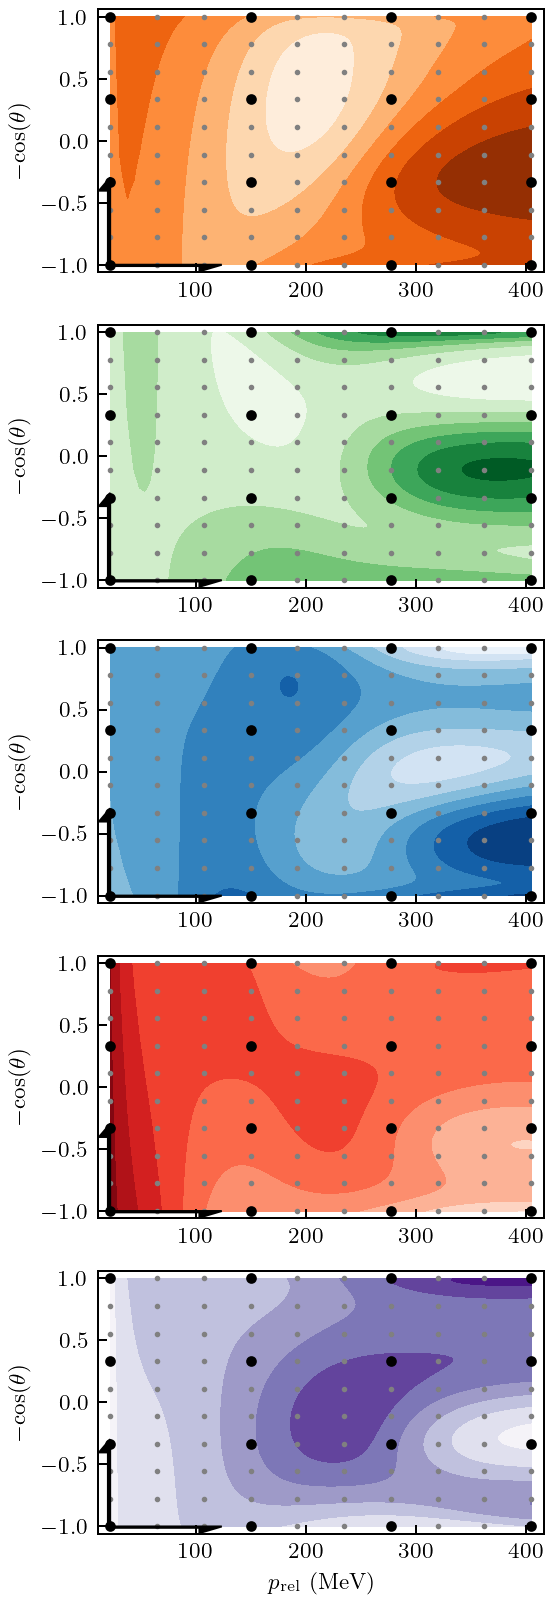

In [11]:
My2DPlot.plot_coefficients(whether_save=False)

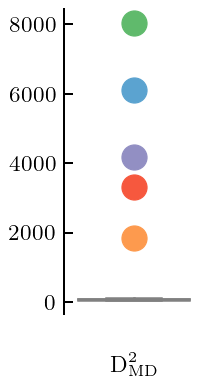

In [12]:
My2DPlot.plot_md(whether_save=False)

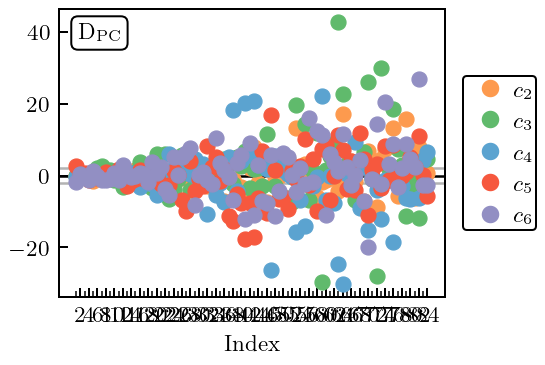

In [13]:
My2DPlot.plot_pc(whether_save=False)

In [14]:
# a = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
# # ar = np.reshape(np.tile(a, (2, 1, 1)), (3, 3, 2), order = 'F')
# ar = np.tile(a, (2, 1, 1))
# print(
#     np.shape(ar)
# )
# print(
#     ar
# )
# # print(
# #     np.shape(np.repeat(a, 2, axis = 1))
# # )
# # print(
# #     np.repeat(a, 2, axis = 1)
# # )
# # print(
# #     np.concatenate(, )
# # )
# # print(
# #     np.shape(np.swapaxes(np.tile(a, (2, 1, 1)), 0, -1))
# # )
# # print(
# #     np.swapaxes(np.tile(a, (2, 1, 1)), 0, -1)
# # )
# # print(
# #     np.shape(np.moveaxis(np.tile(a, (2, 1, 1)), 0, -1))
# # )
# # print(
# #     np.moveaxis(np.tile(a, (2, 1, 1)), 0, -1)
# # )

In [15]:
1/0

ZeroDivisionError: division by zero

In [ ]:
n_orders = 6    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 20  # We are going to treat some high order result as the final, converged answer
orders_array = np.arange(0, n_orders, 1, dtype = int)
orders_all_array = np.arange(0, final_order + 1, 1, dtype = int)

t_lab = np.linspace(1, 351, 51)
degrees = np.linspace(1, 179, 49)

E_lab = t_lab
angle_lab = degrees
# E_angle_pair = [E_lab, angle_lab]
E_angle_pair = [E_lab, angle_lab]

# The true values of the hyperparameters for generating the EFT coefficients
ls_E = 100
ls_deg = 40
sd_gp = 1.0
sd_fixed = None
center = 0
ref = 1
nugget = 1e-10
df = 3
disp = 0
scale = 1.0
seed = 115

# sets 2D momentum mesh
p_toy = p_approx("pprel", E_to_p(t_lab, interaction = "np"), degrees).T
print(np.shape(p_toy))
print(p_toy)
Q_param_toy = "sum"
p_param_toy = "pprel"
mpi_toy = 96
Lambda_b_toy = 431
# if Q is constant, use next line
# ratio = 0.3
# if Q is not constant, use next line
Q_toy = Q_approx(p_toy, "sum", Lambda_b = Lambda_b_toy, m_pi = mpi_toy,
             single_expansion=False)
print(np.shape(Q_toy))
print(Q_toy)

# sets kernels
kernel_toy = RBF(length_scale=(ls_E, ls_deg),
               length_scale_bounds=((ls_E / 4, ls_E * 4),
                                    (ls_deg / 4, ls_deg * 4))) + \
           WhiteKernel(1e-6, noise_level_bounds='fixed')

# creates Gaussian processes
gp_toy = gm.ConjugateGaussianProcess(kernel = kernel_toy, 
                        center = center, df = df, disp = disp, 
                        scale = scale, nugget = 0, sd = sd_fixed)
# generates coefficients randomly up to final_order
coeffs_toy = np.swapaxes(np.reshape(- gp_toy.sample_y(np.array(list(itertools.product(t_lab, degrees))), 
                         n_samples = n_orders, 
                         random_state = seed), (len(t_lab), len(degrees), n_orders)).T, 1, 2)
print(np.shape(coeffs_toy))

In [ ]:
# plots coefficients at an order
fig = plt.figure()
ax = plt.axes(projection="3d")
(XA, XB) = np.meshgrid(degrees, t_lab)
ax.plot_surface(XA, XB, coeffs_toy[0, :, :])

In [ ]:
# generates data using coefficients and other EFT parameters (e.g., dimensionless expansion parameter)
data_toy = gm.partials(
    coeffs = np.reshape(coeffs_toy, (n_orders, len(t_lab) * len(degrees))).T, 
    # if Q is not constant, use next line
    ratio = np.reshape(Q_toy, (len(t_lab) * len(degrees))), 
    # if Q is constant, use next line
#     ratio = ratio,
    ref = ref, 
    orders = orders_array)
print(np.shape(data_toy))
data_toy = np.reshape(data_toy.T, (n_orders, len(t_lab), len(degrees)))
print(np.shape(data_toy))
print(data_toy)

In [ ]:
# plots data at an order
fig = plt.figure()
ax = plt.axes(projection="3d")
(XA, XB) = np.meshgrid(degrees, t_lab)
ax.plot_surface(XA, XB, data_toy[3, :, :])

In [ ]:
ScaleSchemeToy = ScaleSchemeBunch(
    "",
    np.array([0, 1, 2, 3, 4, 5,]),
    [plt.get_cmap(name) for name in ["Oranges", "Greens", "Blues", "Reds", "Purples"]],
    "Toy",
    "Data",
    extra = ["Oranges", "Greens", "Blues", "Reds", "Purples"],
)

OBSToy = ObservableBunch(
            "OBS",
            data_toy,
            E_angle_pair,
            "Obs.",
            "dimensionless",
            unit_string="",
        )

ObservableToy = OBSToy
print(np.shape(ObservableToy.data))
print(ObservableToy.data)

In [ ]:
DegBunch = InputSpaceBunch(
                    "deg",
                    deg_fn,
                    p_approx(
                        "pprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$\theta$ (deg)",
                    [
                        r"$",
                        ObservableToy.title,
                        r"(\theta, E_{\mathrm{lab}}= ",
                        E_lab,
                        "\,\mathrm{MeV})$",
                    ],
                )
# VsQuantity2D = CosBunch
print(np.shape(DegBunch.mom))
print(DegBunch.mom)

ElabBunch = InputSpaceBunch(
                    "Elab",
                    Elab_fn,
                    p_approx(
                        "Qofprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$E_{\mathrm{lab}}$ (MeV)",
                    [r"$", ObservableToy.title, r"(E_{\mathrm{lab}}, \theta= ", angle_lab, "^{\circ})$"],
                )
# VsQuantity2D = PrelBunch
print(np.shape(ElabBunch.mom))
print(ElabBunch.mom)

vsquantity_array_toy = [ElabBunch, DegBunch]
for vsq in vsquantity_array_toy:
    try:
        vsq.make_title()
    except:
        pass

In [ ]:
ls_array_toy = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True), 
            LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)]

for (ls, vsq) in zip(ls_array_toy, vsquantity_array_toy):
    ls.make_guess(
            vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )
        )
    print(np.shape(vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )))
    print(vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            ))
    print(ls.ls_guess)

ratio_toy = Q_approx(
            p_approx("pprel", E_to_p(E_lab, "np"), angle_lab),
            "sum",
            Lambda_b=431,
            m_pi=96,
        ).T
print(np.shape(ratio_toy))
print(ratio_toy)
# print(np.shape(ratio))
# print(ratio)
# if not E_angle_pair[0]:
#     if not E_angle_pair[1]:
#         ratio = ratio[0, :]
#         ratio = np.reshape(ratio, (len(t_lab)))
#     else:
#         ratio = ratio[np.isin(degrees, E_angle_pair[1]), :]
#         ratio = np.reshape(ratio, (len(t_lab)))
# else:
#     ratio = ratio[:, np.isin(t_lab, E_angle_pair[0])]
#     ratio = np.reshape(ratio, (len(degrees)))

# ratio = np.reshape(ratio, len(t_lab) * len(degrees))

GPHyperToy = GPHyperparameters(
            ls_array_toy,
            center = 0,
            ratio = ratio_toy,
            df=1,
            disp=0,
            scale=1,
            seed=None,
            sd=None,
        )

In [ ]:
OrdersToy = OrderInfo(
            ScaleSchemeToy.orders_full,
            [0] + [],
            ScaleSchemeToy.colors,
            ScaleSchemeToy.light_colors,
            orders_names_dict=None,
            orders_labels_dict=None,
        )

In [ ]:
FileNameToy = FileNaming(
                ScaleSchemeToy.potential_string,
                ScaleSchemeToy.cutoff_string,
                "sum",
                "pprel",
                "Elabdeg",
                filename_addendum="",
            )

In [ ]:
fixed_quantity = []
x_quantity = [["energy", E_lab, t_lab, "MeV"], ["angle", angle_lab, degrees, "degrees"]]

In [ ]:
Toy2D = GSUMsandbox(
                    schemescale = ScaleSchemeToy,
                    observable = ObservableToy, 
                    inputspace = vsquantity_array_toy, 
                    traintestsplit = TTS,
                    gphyperparameters = GPHyperToy, 
                    orderinfo = OrdersToy, 
                    filenaming = FileNameToy,
                    fixed_quantity=fixed_quantity,
                    x_quantity=x_quantity, 
)

In [ ]:
Toy2D.plot_coefficients(whether_save=False)

In [ ]:
Toy2D.plot_md(whether_save=False)

In [ ]:
Toy2D.plot_pc(whether_save=False)